<a href="https://colab.research.google.com/github/tjturnage/Google-Colab_Notebooks/blob/main/QPE_Comparator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **QPE Comparator**<br />
A script that downloads MRMS radar-only, MRMS multi-sensor pass 2, Stage IV (RFC/AHPS), and meswoest obs and plots them on a 4-panel plot for comparison.<br /> 
<br /> 
 &nbsp;&nbsp;*Caleb Steele (formerly at NWS Western Region Science & Technology Infusion Division)* <br />
&nbsp;&nbsp;&nbsp;&nbsp;*8-Aug-2022 -- Initial creation<br />
&nbsp;&nbsp;&nbsp;&nbsp;Future plans to regrid and allow difference grids and add NASA GPM (https://gpm.nasa.gov/data/directory)* <br/> <br/> 
&nbsp;&nbsp;*T.J. Turnage (NWS Grand Rapids, MI - thomas.turnage@noaa.gov)
<br />
&nbsp;&nbsp;&nbsp;&nbsp;6-Apr-2023 -- switched from conda to apt/pip installs for GIS libraries*<br/>

In [9]:
#@title
# These libraries are needed for the pygrib library in Colab.
# Note that is needed if you install pygrib using pip.
# If you use conda, the libraries will be installed automatically.
! apt-get install libeccodes-dev libproj-dev --quiet

# Install the python packages
print("pyproj and pygrib installation ...")
! pip install pyproj --quiet
! pip install pygrib --quiet
print("pyproj and pygrib installation complete...")

Reading package lists...
Building dependency tree...
Reading state information...
libeccodes-dev is already the newest version (2.16.0-1).
libproj-dev is already the newest version (7.2.1-1~focal0).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
pyproj and pygrib installation ...
pyproj and pygrib installation complete...


In [10]:
#@title
# Uninstall existing shapely
# We will re-install shapely in the next step by ignoring the binary
# wheels to make it compatible with other modules that depend on
# GEOS, such as Cartopy (used here).
!pip uninstall --yes shapely --quiet
print("old shapely being removed...")

old shapely being removed...


In [11]:
#@title
# To install cartopy in Colab using pip, we need to install the library
# dependencies first.
!apt-get install -qq libgdal-dev libgeos-dev
print("new shapely being installed...")
!pip install shapely --no-binary shapely --quiet
print("new shapely installation complete...")
print("cartopy installation...")
!pip install cartopy --quiet
print("cartopy installation complete...")
!pip install contextily --quiet

new shapely being installed...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
new shapely installation complete...
cartopy installation...
cartopy installation complete...


In [12]:
#@title
print("Almost done! Installing netCDF4 and rioxarry...")
!pip install netCDF4 --quiet
!pip install rioxarray --quiet
print("netCDF4 and rioxarry installation complete!")
print("Now to the next step to import modules...")

Almost done! Installing netCDF4 and rioxarry...
netCDF4 and rioxarry installation complete!
Now to the next step to import modules...


# **Now that everything has been installed, it's time to import modules...**<br />

In [13]:
#@title
import numpy as np
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from cartopy import cartopy, crs as ccrs, feature as cfeature

import rioxarray as rxr
import pygrib
import netCDF4 as nc
import pandas as pd
import json
from pyproj.crs import CRS

from datetime import datetime, timedelta
import contextily as cx

import warnings
warnings.filterwarnings("ignore")

 > Getting MRMS radar-only
   >> Got it!
 > Getting MRMS multi-sensor
   >> Got it!
 > Getting Stage IV
   >> Got it!
 > Getting obs
    >> Huzzah! Got em
Processing data...
  > MRMS radar-only max: 4.96456961
  > MRMS multi-sensor max: 3.20866315
  > StageIV max: 6.610236167907715
Now making QPE plot...
 > Setting up 4-panel map
 > Adding map tiles
 > Contouring MRMS radar-only
 > Contouring MRMS multi-sensor (pass 2)
 > Contouring Stage IV
 > Plotting obs
 > Saving file as GRR_qpe4p1_20230404_12.png
Done!


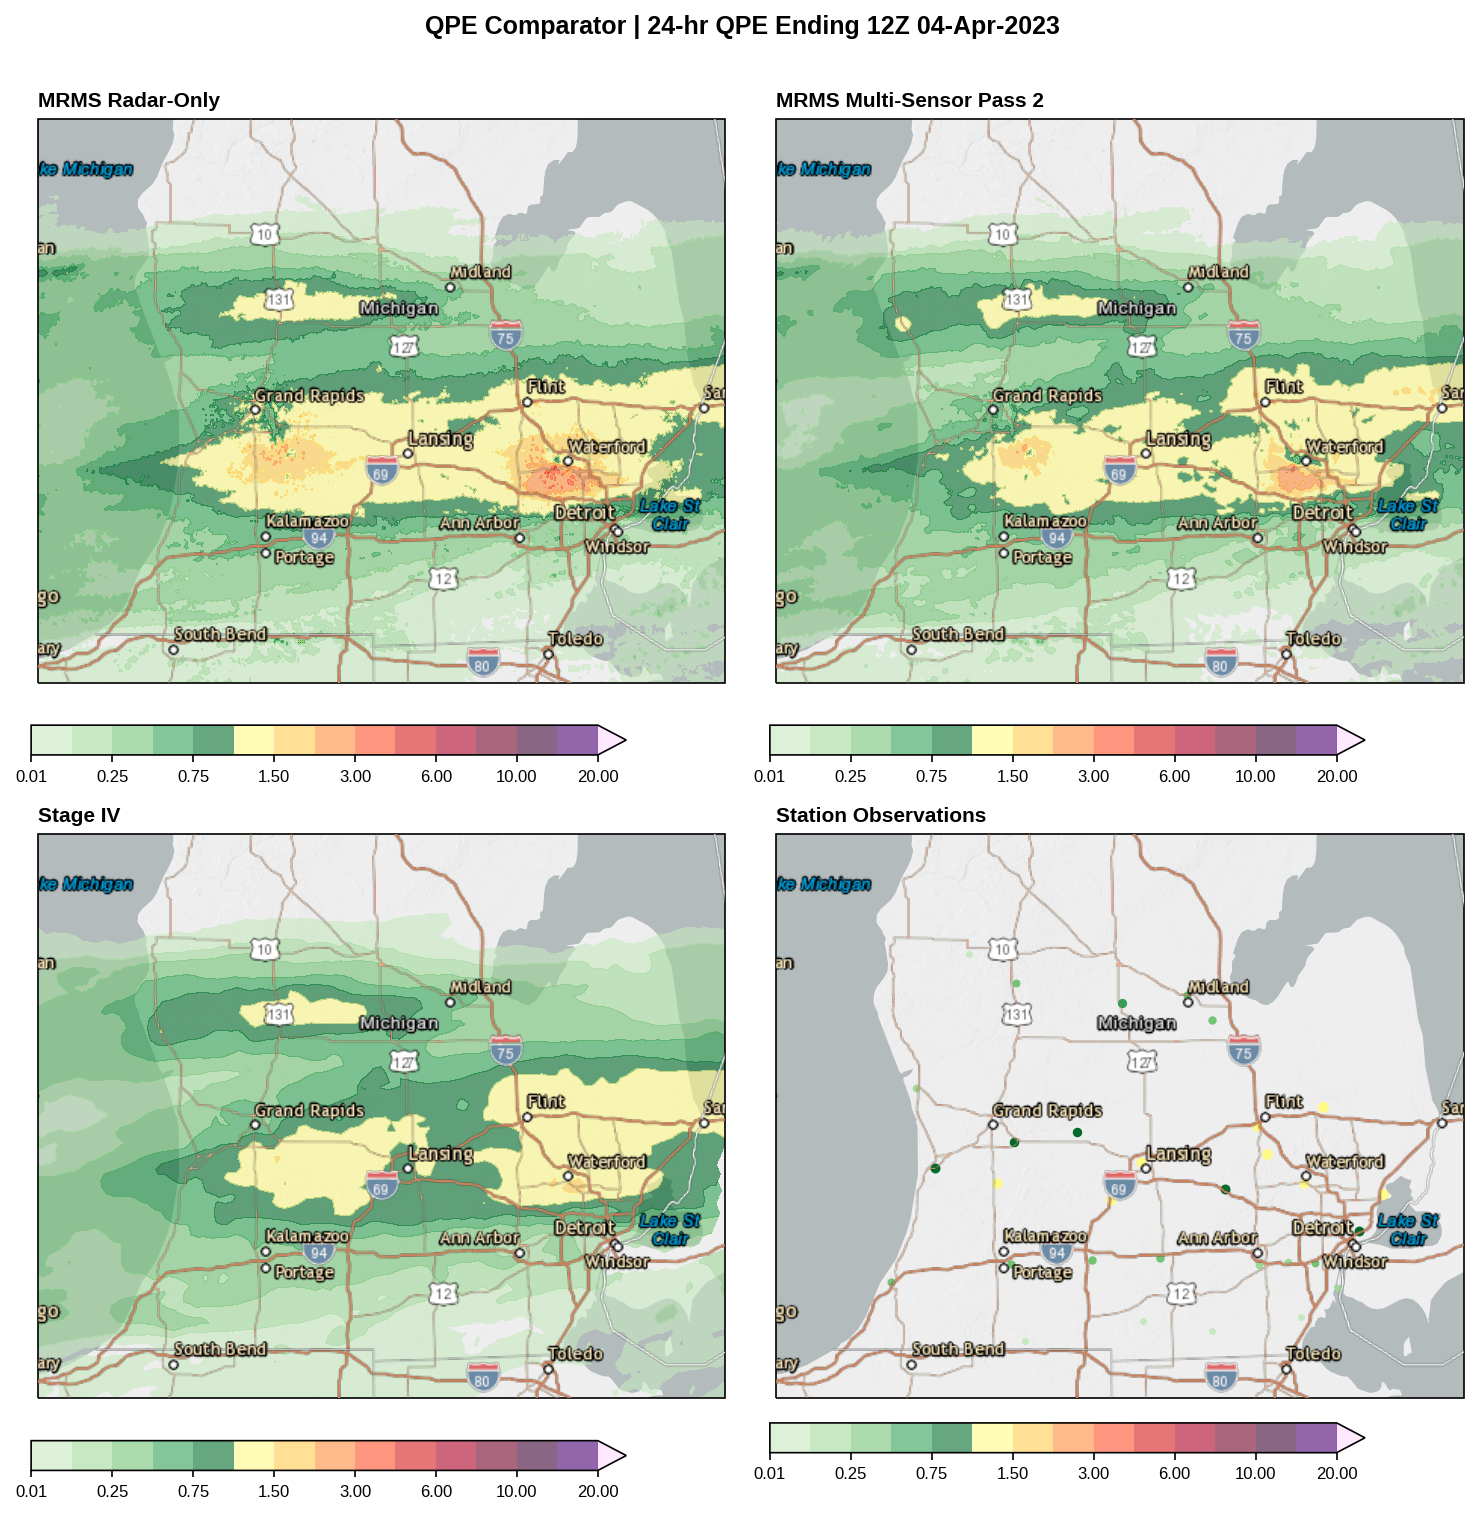

In [16]:
#@title QPE Comparator Inputs { display-mode: "form" }
valid_date_input = "2023-04-04" #@param {type:"date"}
valid_date = datetime.strptime(valid_date_input,'%Y-%m-%d')
valid_date = valid_date + timedelta(hours= 12)
qpe_valid_time = valid_date.strftime('%HZ %d-%b-%Y')

domain = "GRR" #@param ["GRR","CONUS","ECONUS","WR","VEF","ID-MT","UT","SWUS","AZ","PNW","SR","ER","CR", "co", "midwest","Custom"]
#@markdown Do you know obs plotted as dots or numbers?
ob_markers = "Dots" #@param ["Dots","Values"]

#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  41.5 #@param {type:"number"}
custom_left_lon = -87.25 #@param {type:"number"}
custom_top_lat =  44.5#@param {type:"number"}
custom_right_lon = -82.25 #@param {type:"number"}

#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "Grand_Rapids" #@param {type:"string"}


mrms_url_base = "https://mtarchive.geol.iastate.edu/"
mrms_radaronly_file = "RadarOnly_QPE_24H_00.00_" + valid_date.strftime('%Y%m%d-%H0000') + ".grib2"
mrms_radaronly_url = mrms_url_base + valid_date.strftime('%Y/%m/%d') + "/mrms/ncep/RadarOnly_QPE_24H/" + mrms_radaronly_file + ".gz"
mrms_multisensor_file = "MultiSensor_QPE_24H_Pass2_00.00_" + valid_date.strftime('%Y%m%d-%H0000') + ".grib2"
mrms_multisensor_url = mrms_url_base + valid_date.strftime('%Y/%m/%d') + "/mrms/ncep/MultiSensor_QPE_24H_Pass2/" + mrms_multisensor_file + ".gz"

s4_url_base = "https://water.weather.gov/precip/downloads/"
s4_file = "nws_precip_1day_" + valid_date.strftime('%Y%m%d') + "_conus.nc"
s4_url = s4_url_base + valid_date.strftime('%Y/%m/%d') + "/" + s4_file



latloncrs = ccrs.PlateCarree()
webmerccrs = ccrs.Mercator.GOOGLE
domain_dict = {"Custom":{"west":custom_left_lon,
                        "east":custom_right_lon,
                        "north":custom_top_lat,
                        "south":custom_bottom_lat,
                        "zoom_adj": 1,
                        "legend":3},
               "GRR":{"west":-87.25,
                    "south":41.5,
                    "east":-82.25,
                    "north":44.5,
                    "zoom_adj": 1,
                     "legend":4},
               "WR":{"west":-126.917,
                    "south":30.586,
                    "east":-102.740,
                    "north":49.755,
                    "zoom_adj": 1,
                     "legend":4},

               "UT":{"west":-117.02,
                      "east":-106.92,
                      "north":42.13,
                      "south":36.80,
                      "zoom_adj": 1,
                     "legend":4},
               
               "VEF":{"west":-119.003,
                      "east":-112.325,
                      "north":38.786,
                      "south":33.855,
                      "zoom_adj": 1,
                     "legend":4},
               
               "ID-MT":{"west":-117.5177,
                    "south":41.9071,
                    "east":-103.38071,
                    "north":49.3085,
                    "zoom_adj": 1,
                    "legend":4},
               
               "PNW":{"west":-125.4510,
                    "south":41.8754,
                    "east":-110.9318,
                    "north":49.5767,
                    "zoom_adj": 1,
                    "legend":4},
               
               "SWUS":{"west":-125.582,
                    "south":31.136,
                    "east":-108.689,
                    "north":42.859,
                    "zoom_adj": 1,
                    "legend":3},
               
               "AZ":{"west":-115.596,
                    "south":31.113,
                    "east":-107.887,
                    "north":37.446,
                    "zoom_adj": 1,
                    "legend":4},
               
               "SR":{"west":-109.758,
                    "south":23.313,
                    "east":-78.247,
                    "north":37.899,
                    "zoom_adj": 1,
                    "legend":3},
               
               "CR":{"west":-111.534,
                    "south":35.118,
                    "east":-82.263,
                    "north":49.755,
                    "zoom_adj": 1,
                    "legend":1},
               
               "ER":{"west":-85.629,
                    "south":31.723,
                    "east":-66.465,
                    "north":47.676,
                    "zoom_adj": 1,
                    "legend":4},
               
               "CONUS":{"west":-125.650,
                    "south":23.377,
                    "east":-66.008,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},
               
               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 1,
                    "legend":4},

}

west = domain_dict[domain]["west"]
south = domain_dict[domain]["south"]
east = domain_dict[domain]["east"]
north = domain_dict[domain]["north"]
map_zoom_offset = domain_dict[domain]["zoom_adj"]
LLOC = domain_dict[domain]["legend"]

zoom = (cx.tile._calculate_zoom(west, 
                                    south, 
                                    east, 
                                    north) - map_zoom_offset)

def mm_to_in(input):
  inches = np.multiply(input, 0.0393701)
  return inches

def get_mrms(url, file):
  if os.path.exists("mrms"):
    pass
  else:
    os.system('mkdir mrms')
  
  full_file = "mrms/"+file+".gz"
  urlretrieve(url, full_file)
  unzip_command = f'gunzip {full_file}'
  os.system(unzip_command)

def get_s4(url, file):
  if os.path.exists("stageIV"):
    pass
  else:
    os.system('mkdir stageIV')
  
  full_file = "stageIV/"+file
  urlretrieve(url, full_file)


def get_obs(url, file):
  if os.path.exists("obs"):
    pass
  else:
    os.system('mkdir obs')
  
  full_file = "obs/"+file
  urlretrieve(url, full_file)

def get_obcolor(amount):
  if amount == 0.0:
    color = "#ffffff"
  elif amount >= 0.01 and amount < 0.10:
    color = "#c7e9c0"
  elif amount >= 0.10 and amount < 0.25:
    color = "#a1d99b"
  elif amount >= 0.25 and amount < 0.50:
    color = "#74c476"
  elif amount >= 0.50 and amount < 0.75:
    color = "#31a353"
  elif amount >= 0.75 and amount < 1.0:
    color = "#006d2c"
  elif amount >= 1.0 and amount < 1.5:
    color = "#fffa8a"
  elif amount >= 1.5 and amount < 2.0:
    color = "#ffcc4f"
  elif amount >= 2.0 and amount < 3.0:
    color = "#fe8d3c"
  elif amount >= 3.0 and amount < 4.0:
    color = "#fc4e2a"
  elif amount >= 4.0 and amount < 6.0:
    color = "#d61a1c"
  elif amount >= 6.0 and amount < 8.0:
    color = "#ad0026"
  elif amount >= 8.0 and amount < 10.0:
    color = "#700026"
  elif amount >= 10.0 and amount < 15.0:
    color = "#3b0030"
  elif amount >= 15.0 and amount < 20.0:
    color = "#4c0073"
  elif amount >= 20:
    color = "#ffdbff"
  else:
     color = '#ffffff'
  return color


def mask_trim(data, lats, lons):
  west_mask = np.where(lons < (west+360.), np.nan, data)
  east_mask = np.where(lons > (east+360.), np.nan, west_mask)
  south_mask = np.where(lats < south, np.nan, east_mask)
  data_masked = np.where(lats > north, np.nan, south_mask)
  nans = np.isnan(data_masked)
  nancols = np.all(nans, axis=0)
  nanrows = np.all(nans, axis=1)
  firstcol = nancols.argmin()
  firstrow = nanrows.argmin()
  lastcol = len(nancols) - nancols[::-1].argmin()
  lastrow = len(nanrows) - nanrows[::-1].argmin()
  data_crop = data[firstrow:lastrow,firstcol:lastcol]
  lons_crop = lons[firstrow:lastrow,firstcol:lastcol]
  lats_crop = lats[firstrow:lastrow,firstcol:lastcol]
  return data_crop, lons_crop, lats_crop

##### Now download data ##########
print("Downloading data...")
print(" > Getting MRMS radar-only")
try:
  get_mrms(mrms_radaronly_url, mrms_radaronly_file)
  print("   >> Got it!")
except:
  print('   !>> Shucks, cant get MRMS radar-only')

print(" > Getting MRMS multi-sensor")
try:
  get_mrms(mrms_multisensor_url, mrms_multisensor_file)
  print("   >> Got it!")
except:
  print('   !>> Shucks, cant get MRMS multi-sensor')

print(" > Getting Stage IV")
try:
  get_s4(s4_url, s4_file)
  print("   >> Got it!")
except:
  print('   !>> Shucks, cant get Stage IV')

print(" > Getting obs")
precip_api = "https://api.synopticdata.com/v2/stations/precipitation?"
token = "d919c72620984d32a5503b37678f4a8f"
api_token = "&token="+token
query_var = "&pmode=totals&obtimezone=utc&units=precip|in"
query_stations = "&network=1,2"
bbox_str = str(west+0.25)+","+str(south+0.25)+","+str(east-0.25)+","+str(north-0.25)
query_area = "&bbox="+bbox_str
obs_end = valid_date.strftime('%Y%m%d%H%M')
obs_starttime = valid_date - timedelta(hours=24)
obs_start = obs_starttime.strftime('%Y%m%d%H%M')
query_time = "&start="+obs_start+"&end="+obs_end
query_extras = "&fields=latitude,longitude"
obs_url = precip_api + api_token + query_var + query_area + query_stations + query_time + query_extras

obs_name = domain+"_obs_"+obs_start+"_"+obs_end+".json"
try:
  get_obs(obs_url, obs_name)
  ob_lats = []
  ob_lons = []
  ob_stid = []
  ob_ptotal = []
  ob_color = []
  if os.path.exists("obs/"+obs_name):
    with open("obs/"+obs_name) as json_file:
      obs_json = json.load(json_file)
      for stn in obs_json["STATION"]:
        olat = stn["LATITUDE"]
        olon = stn["LONGITUDE"]
        if stn["STID"] is None:
          stid = "N0N3"
        else:
          stid = stn["STID"]
        if "precipitation" in stn["OBSERVATIONS"]:
          if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
            ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
            if ptotal >= (0.01):
              ob_lats.append(float(olat))
              ob_lons.append(float(olon))
              ob_stid.append(stid)
              ob_ptotal.append(round(ptotal,2))
              ob_color.append(get_obcolor(ptotal))
  print('    >> Huzzah! Got em')
except:
  print('   !> Womp womp, couldnt get obs!')


##### Now read/process data ##########
print("Processing data...")
try:
  mrms_ro_grb = pygrib.open("mrms/"+mrms_radaronly_file)
  mrms_ro = mrms_ro_grb.message(1).values
  mrms_ro_in = mm_to_in(mrms_ro)
  mrolats, mrolons = mrms_ro_grb.message(1).latlons()
  mro_anal_time = mrms_ro_grb.message(1).analDate
  mro_vtime = mrms_ro_grb.message(1).validDate
  mrms_ro_grb.close()
  mrms_ro_in_crop, mrolons_crop, mrolats_crop = mask_trim(mrms_ro_in, mrolats, mrolons)
  print(f'  > MRMS radar-only max: {np.max(mrms_ro_in_crop)}')
except:
  print(' !> Problem with MRMS radar-only file!')

try:
  mrms_ms_grb = pygrib.open("mrms/"+mrms_multisensor_file)
  mrms_ms = mrms_ms_grb.message(1).values
  mrms_ms_in = mm_to_in(mrms_ms)
  mmslats, mmslons = mrms_ms_grb.message(1).latlons()
  mms_anal_time = mrms_ms_grb.message(1).analDate
  mmd_vtime = mrms_ms_grb.message(1).validDate
  mrms_ms_grb.close()
  mrms_ms_in_crop, mmslons_crop, mmslats_crop = mask_trim(mrms_ms_in, mmslats, mmslons)
  print(f'  > MRMS multi-sensor max: {np.max(mrms_ms_in_crop)}')
except:
  print(' !> Problem with MRMS multi-sensor file!')


try:
  s4ds = nc.Dataset("stageIV/"+s4_file, 'r')
  stageIV = s4ds.variables['observation'][:][:]
  xs = s4ds.variables['x'][:]
  ys = s4ds.variables['y'][:]
  s4_x, s4_y = np.meshgrid(xs, ys)
  globe = ccrs.Globe(semimajor_axis=6371200)
  s4_proj = ccrs.Stereographic(central_latitude=90.0,
                            central_longitude=255.0,
                            true_scale_latitude=60.0, globe=globe)
  print(f'  > StageIV max: {np.max(stageIV)}')
except:
  print(' !> Problem with Stage IV file!')




##### Now onto plotting! ##########
print('Now making QPE plot...')
matplotlib.rcParams['figure.dpi'] = 150 # make high quality figure
print(' > Setting up 4-panel map')
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), subplot_kw={'projection': webmerccrs}, frameon=True)
axlist = axarr.flatten()
pcp_levs = [0.01, 0.10, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 10., 15., 20.]
pcp_cols = ["#c7e9c0", # 0.01 - 0.10"
            "#a1d99b", # 0.10 - 0.25"
            "#74c476", # 0.25 - 0.5"
            "#31a353", # 0.5 - 0.75"
            "#006d2c", # 0.75 - 1.0"
            "#fffa8a", # 1.0 - 1.5"
            "#ffcc4f", # 1.5 - 2.0"
            "#fe8d3c", # 2.0 - 3.0"
            "#fc4e2a", # 3.0 - 4.0"
            "#d61a1c", # 4.0 - 6.0"
            "#ad0026", # 6.0 - 8.0"
            "#700026", # 8.0 - 10.0"
            "#3b0030", # 10.0 - 15.0"
            "#4c0073", # 15.0 - 20.0"
            "#ffdbff" # 20.0+"
            ]

pcp_diff_levs = [-1.0, -0.5, -0.25, -0.10, -0.01, 0.01, 0.10, 0.25, 0.5, 1.0]
pcp_diff_cols = ["#54300599", "#8c510a99", "#bf812d99", "#dfc27d99", "#f6e8c399",
                 "#f5f5f500", "#c7eae599", "#80cdc199", "#35978f99", "#01665e99", "#003c3099"]
cbar_ticklabel_size = 8.
titlefont_size = 10.

print(' > Adding map tiles')
for axs in [0,1,2,3]:
  axn = axlist[axs]
  axn.set_extent([west, east, south, north], crs=latloncrs)
  cx.add_basemap(axn, source="https://api.maptiler.com/tiles/hillshade/{z}/{x}/{y}.webp?key=u9mtRM6NxhP00ezZ9tSz", 
                    attribution=False, crs=CRS.from_epsg(3857), zorder=-1)
  axn.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
  cx.add_basemap(axn, source="http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}", 
                  attribution=False, crs=CRS.from_epsg(3857), zoom=zoom, zorder=50)
  cx.add_basemap(axn, source='http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                   crs=CRS.from_epsg(3857), zoom=zoom, zorder=49)

print(' > Contouring MRMS radar-only')
radar = axlist[0].contourf(mrolons_crop, mrolats_crop, mrms_ro_in_crop, levels=pcp_levs, colors=pcp_cols, extend='max', alpha=0.6, transform=latloncrs, transform_first=True)
cbar0 = plt.colorbar(radar, ax=axlist[0], orientation='horizontal', anchor=(0.0, 0.5), pad=0.01, shrink=0.85)
cbar0.ax.tick_params(labelsize=cbar_ticklabel_size)
axlist[0].set_title('MRMS Radar-Only', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')

print(' > Contouring MRMS multi-sensor (pass 2)')
pass2 = axlist[1].contourf(mmslons_crop, mmslats_crop, mrms_ms_in_crop, levels=pcp_levs, colors=pcp_cols, extend='max', alpha=0.6, transform=latloncrs, transform_first=True)
cbar1 = plt.colorbar(pass2, ax=axlist[1], orientation='horizontal',anchor=(0.0, 0.5), pad=0.01, shrink=0.85)
cbar1.ax.tick_params(labelsize=cbar_ticklabel_size)
axlist[1].set_title('MRMS Multi-Sensor Pass 2', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')

#mrms_multi_radar_difference = np.subtract(mrms_ms_in_crop, mrms_ro_in_crop)
#diff = axlist[2].contourf(mmslons_crop, mmslats_crop, mrms_multi_radar_difference, levels=pcp_diff_levs, colors=pcp_diff_cols, extend='both', transform=latloncrs, transform_first=True)
#cbar2 = plt.colorbar(diff, ax=axlist[2], orientation='horizontal', anchor=(0.0, 0.5), pad=0.01, shrink=0.85)
#axlist[2].set_title('MRMS Multi-Sensor -- Radar-Only Difference', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')
#cbar2.ax.tick_params(labelsize=cbar_ticklabel_size)
print(' > Contouring Stage IV')
s4map = axlist[2].contourf(s4_x, s4_y, stageIV, levels=pcp_levs, colors=pcp_cols, extend='max', alpha=0.6, transform=s4_proj, transform_first=True)
cbar2 = plt.colorbar(s4map, ax=axlist[2], orientation='horizontal', anchor=(0.0, 0.5), pad=0.01, shrink=0.85)
axlist[2].set_title('Stage IV', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')
cbar2.ax.tick_params(labelsize=cbar_ticklabel_size)

print(' > Plotting obs')
for report in range(0, len(ob_ptotal)):
  if ob_markers == "Values":
    axlist[3].text(ob_lons[report], ob_lats[report],ob_ptotal[report],fontsize=8+ob_ptotal[report],color=ob_color[report],
            path_effects=[PathEffects.withStroke(linewidth=0.5,foreground='k')],transform=latloncrs, 
            zorder=(25+ob_ptotal[report]))
  elif ob_markers == "Dots":
    axlist[3].scatter(ob_lons[report], ob_lats[report], s=(5+(10*ob_ptotal[report])), color=ob_color[report], 
                      zorder=(25+ob_ptotal[report]),transform=latloncrs)

cbar3 = plt.colorbar(pass2, ax=axlist[3], orientation='horizontal',anchor=(0.0, 0.75), pad=0.01, shrink=0.85)
cbar3.ax.tick_params(labelsize=cbar_ticklabel_size)
axlist[3].set_title('Station Observations', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')

  
plt.suptitle(f'QPE Comparator | 24-hr QPE Ending {qpe_valid_time}', y=1.01, fontweight='bold')
fig.tight_layout()
if domain == "Custom" and custom_name:
  custom_name_sanitized = custom_name.replace(" ","")
  filename = custom_name_sanitized+"_qpe4p1_"+valid_date.strftime('%Y%m%d_%H')+".png"
else:
  filename = domain+"_qpe4p1_"+valid_date.strftime('%Y%m%d_%H')+".png"
print(f' > Saving file as {filename}')
plt.savefig(filename,bbox_inches='tight', facecolor="#FFFFFF") # Saves the figure with small margins
print('Done!')
plt.show()


Did you want to see the difference between MRMS radar-only and MRMS multi-sensor QPE? Run the cell below!

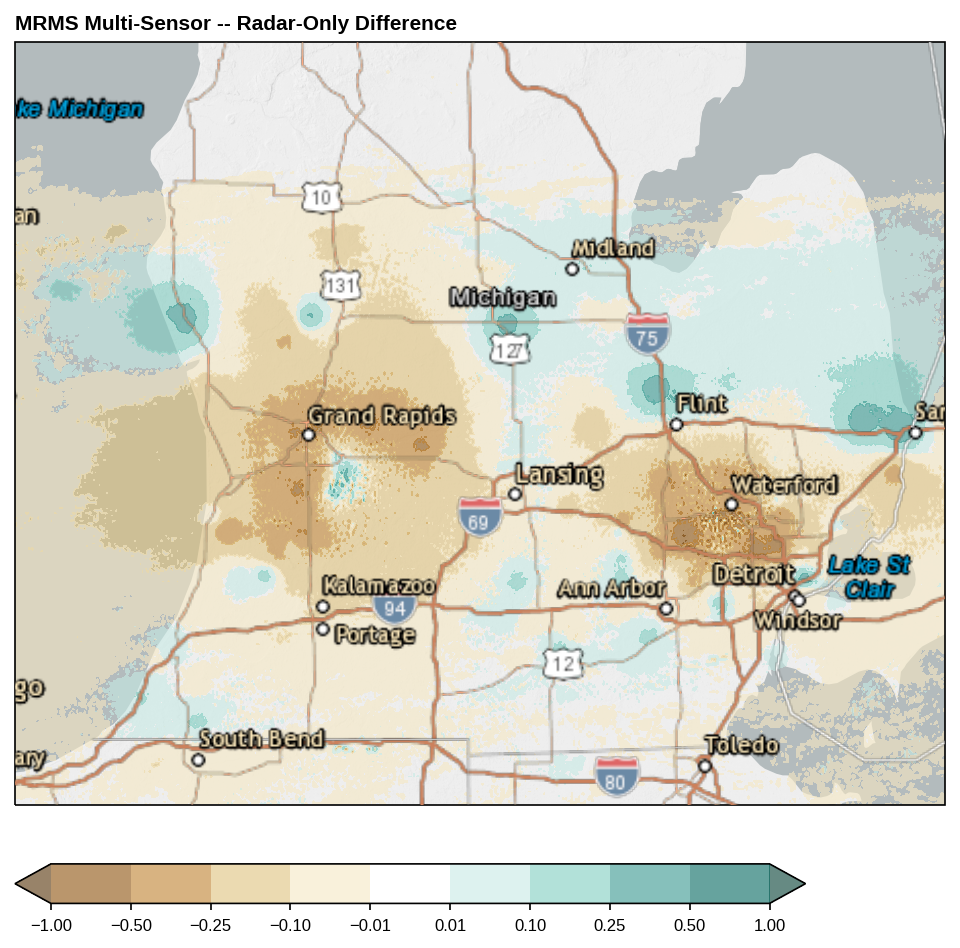

In [17]:
#@title
matplotlib.rcParams['figure.dpi'] = 150 # make high quality figure

plt.figure(figsize=(8, 8), frameon=True)
ax = plt.axes(projection=webmerccrs)

ax.set_extent([west, east, south, north], crs=latloncrs)
cx.add_basemap(ax, source="https://api.maptiler.com/tiles/hillshade/{z}/{x}/{y}.webp?key=u9mtRM6NxhP00ezZ9tSz", 
                  attribution=False, crs=CRS.from_epsg(3857), zorder=-1)
ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
cx.add_basemap(ax, source="http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}", 
                attribution=False, crs=CRS.from_epsg(3857), zoom=zoom, zorder=50)
cx.add_basemap(ax, source='http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                   crs=CRS.from_epsg(3857), zoom=zoom, zorder=49)

mrms_multi_radar_difference = np.subtract(mrms_ms_in_crop, mrms_ro_in_crop)
diff = ax.contourf(mmslons_crop, mmslats_crop, mrms_multi_radar_difference, levels=pcp_diff_levs, colors=pcp_diff_cols, extend='both', transform=latloncrs, transform_first=True)
cbar5 = plt.colorbar(diff, ax=ax, orientation='horizontal', anchor=(0.0, 0.5), pad=0.01, shrink=0.85)
ax.set_title('MRMS Multi-Sensor -- Radar-Only Difference', fontsize=titlefont_size, fontweight='bold', y=1.00, loc='left')
cbar5.ax.tick_params(labelsize=cbar_ticklabel_size)

fig.tight_layout()
if domain == "Custom" and custom_name:
  custom_name_sanitized = custom_name.replace(" ","")
  filename = custom_name_sanitized+"_mrms_diff_"+valid_date.strftime('%Y%m%d_%H')+".png"
else:
  filename = domain+"_mrms_diff_"+valid_date.strftime('%Y%m%d_%H')+".png"
plt.savefig(filename,bbox_inches='tight', facecolor="#FFFFFF") # Saves the figure with small margins
plt.show()